# Roll decay test parameter sensitivity many


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
import copy
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [ ]:
122/(19*2*3.14)

In [6]:
exclude_files = ['20084871055k.06.asc','20084871055k.03.asc'
                ]
acii_directory_path = os.path.join(rolldecay.data_path,'project1','Ascii files')
file_names = []
for file_name in os.listdir(acii_directory_path):
    file_names.append(file_name)
    
file_names = list(set(file_names) - set(exclude_files))


1.022460610124036

In [3]:
exclude_files = ['20084871055k.06.asc','20084871055k.03.asc'
                ]
acii_directory_path = os.path.join(rolldecay.data_path,'project1','Ascii files')
file_names = []
for file_name in os.listdir(acii_directory_path):
    file_names.append(file_name)
    
file_names = list(set(file_names) - set(exclude_files))


In [4]:
def fit(pipeline):
    
    pipelines = {}
    
    for file_name in file_names:
        
        ascii_file_path = os.path.join(acii_directory_path,file_name)
        df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
        
        # Exclude tests where roll is not big enough:
        if ((df_raw['phi'].max() < np.deg2rad(1)) |
            (df_raw['phi'].min() > -np.deg2rad(1))):
            continue
        
        
        pipeline = copy.deepcopy(pipeline)
        pipeline.fit(X=df_raw)
        pipelines[file_name] = pipeline
        
    return pipelines

In [5]:
def predict(pipelines):
    
    df = pd.DataFrame()
    
    for file_name, pipeline in pipelines.items():
        
        estimator = pipeline[-1]
        s = pd.Series(estimator.parameters, name=file_name)
        s['score'] = estimator.score(X=estimator.X)
        s['mean_damping'] = estimator.calculate_average_linear_damping()
        df = df.append(s)
        
    return df

## Direct

In [6]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.4)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(1))
offset_transformer = OffsetTransformer()
bounds = {
    'zeta':(0,np.inf),  # Only positive damping
    'd':(0,np.inf),  # Only positive damping
}
direct_estimator = DirectEstimator(bounds=bounds)

steps = [
('filter',lowpass_filter),
('scaler',scaler),
('cutter', cutter), 
('offset_transformer',offset_transformer),
('direct_estimator', direct_estimator)]
    
pipeline_direct = Pipeline(steps) # define the pipeline object.

In [7]:
pipeline_directs = fit(pipeline=pipeline_direct)

In [8]:
pipeline = pipeline_directs['20084871051k.01.asc']

In [9]:
df_direct = predict(pipelines=pipeline_directs)

## Norwegian

In [10]:
norwegian_estimator = NorwegianEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', norwegian_estimator)]
        
pipeline_norwegian = Pipeline(steps) # define the pipeline object.   

In [11]:
pipeline_norwegians = fit(pipeline=pipeline_norwegian)

In [12]:
df_norwegian = predict(pipelines=pipeline_norwegians)

## Linear method

In [13]:
direct_linear_estimator = DirectLinearEstimator()

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', direct_linear_estimator)]
        
pipeline_direct_linear = Pipeline(steps) # define the pipeline object.   

In [14]:
pipeline_direct_linears = fit(pipeline=pipeline_direct_linear)

In [15]:
df_direct_linear = predict(pipelines=pipeline_direct_linears)
df_direct_linear['d']=0

In [16]:
mask = df_direct['score'] > 0.90
df_direct_good = df_direct.loc[mask].copy()
df_direct_linear_good = df_direct_linear.loc[mask].copy()
df_norwegian_good = df_norwegian.loc[mask].copy()



In [17]:
df1 = df_direct_good.sort_values(by='score', ascending=False).iloc[-10:]
#df1 = df_direct_good.sort_values(by='score', ascending=False).iloc[0:10]
index = df1.index.copy()
df1.reset_index(inplace=True)

df1['method'] = 'direct'
df2 = df_direct_linear_good.loc[index].reset_index()
df2['method'] = 'direct linear'
df3 = df_norwegian_good.loc[index].reset_index()
df3['method'] = 'norwegian'


df_comparison = pd.concat([df1,df2,df3], sort=False)

In [18]:
df_comparison.isnull().any()

index           False
d               False
mean_damping    False
omega0          False
score           False
zeta            False
method          False
dtype: bool

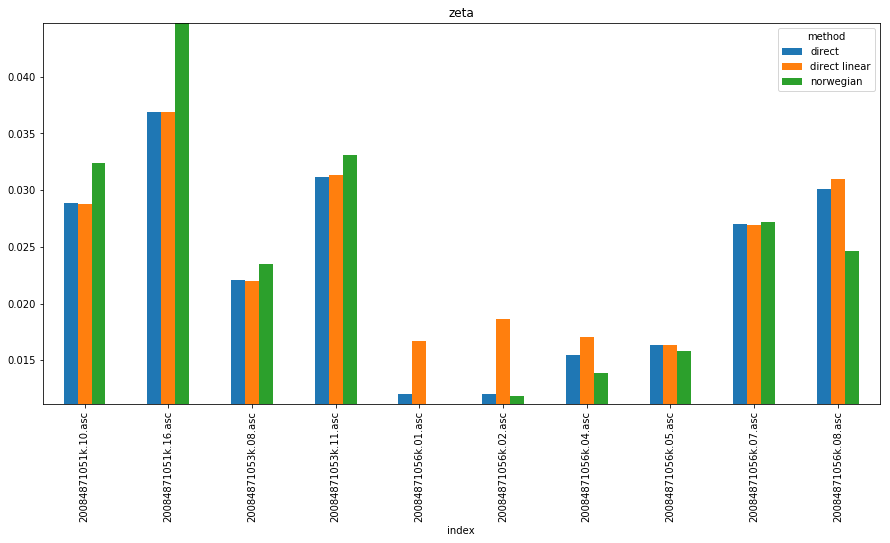

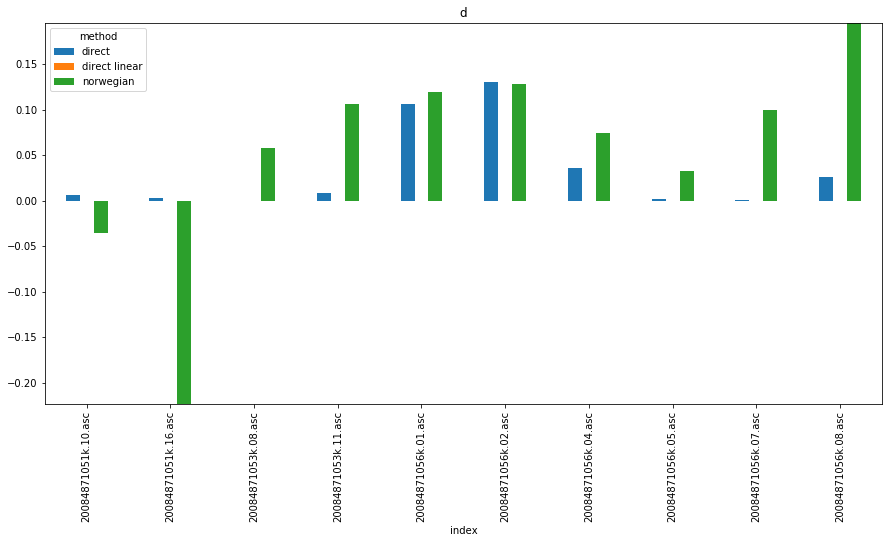

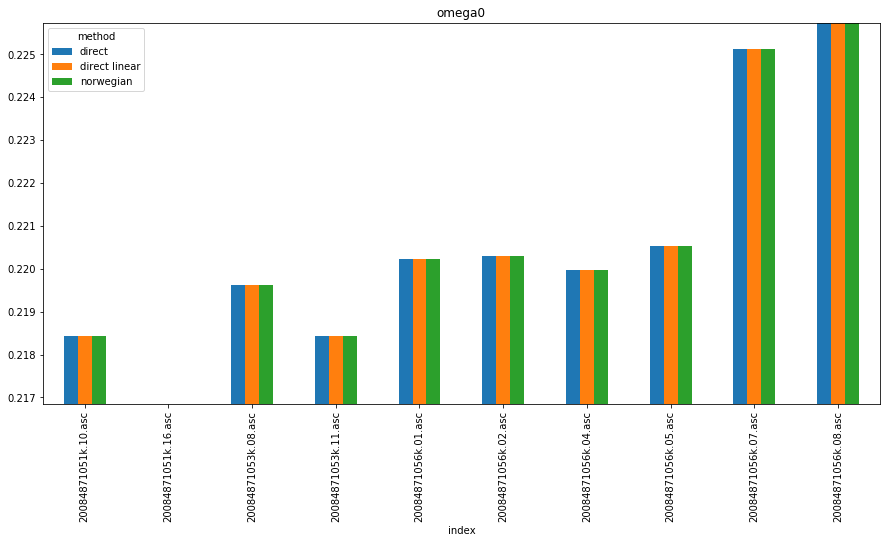

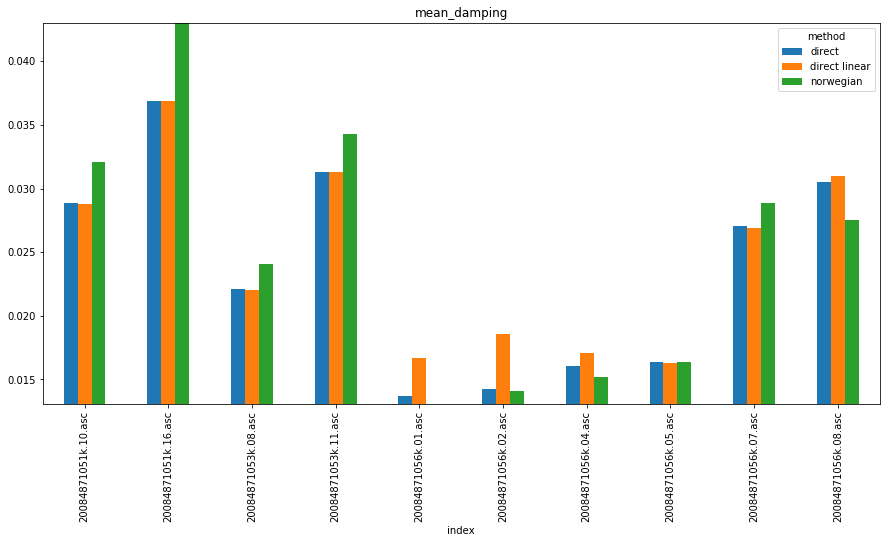

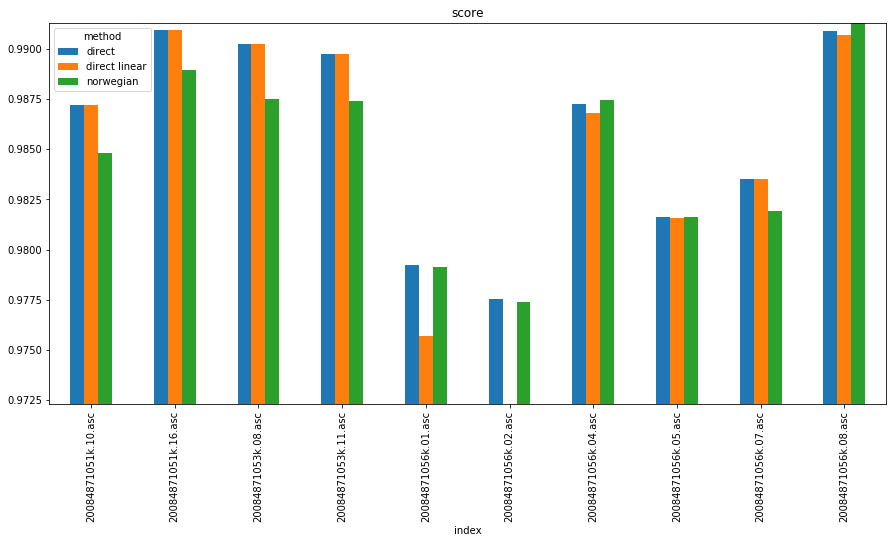

In [19]:
for column in ['zeta','d','omega0','mean_damping','score']:
    fig,ax = plt.subplots()
    
    df = df_comparison.pivot(index='method',columns='index', values=column).transpose()
    df.plot(kind='bar', ax=ax)
    ylim = ax.get_ylim()
    ax.set_ylim(df.min().min(),df.max().max())
    ax.set_title(column)


In [20]:
file = df_direct_good.iloc[0].name
file

'20084871054k.07.asc'

DirectEstimator:0.9909023668478927
DirectLinearEstimator:0.9906891350015461
NorwegianEstimator:0.9913036959463456


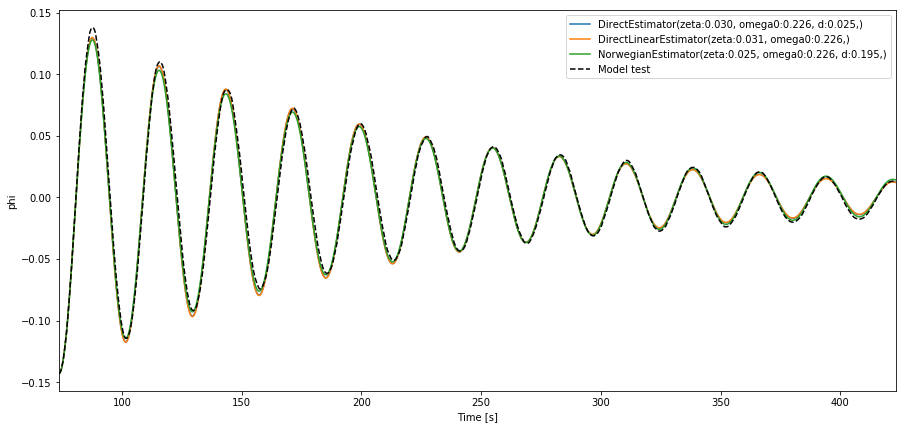

In [21]:
#file = df_direct_good.iloc[0].name
file = '20084871056k.08.asc'


pipelines = [pipeline_directs, pipeline_direct_linears, pipeline_norwegians]

fig,ax = plt.subplots()
for p in pipelines:

    pipeline = p[file]
    estimator = pipeline[-1]
    estimator.plot_fit(ax=ax, model_test=False)
    print('%s:%s' % (estimator.__class__.__name__,estimator.score(X=estimator.X)))

estimator.X.plot(y='phi', label='Model test', ax=ax, style='k--');
ax.legend()


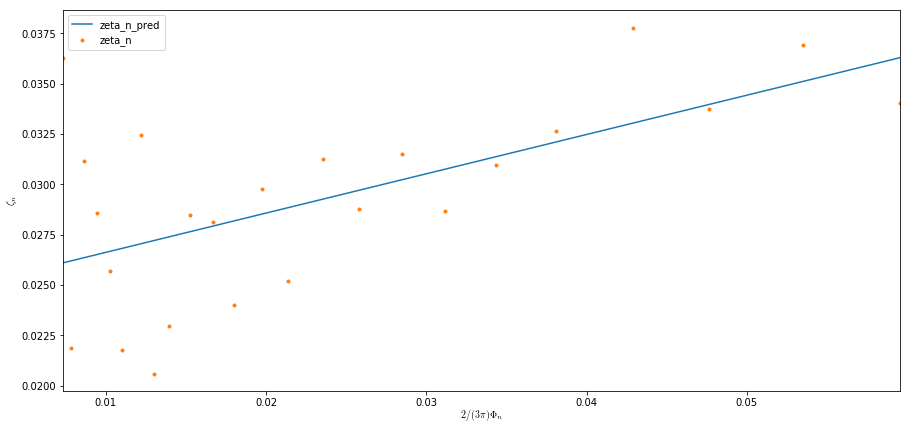

In [22]:
pipeline = pipeline_norwegians[file]
estimator = pipeline[-1]
estimator.plot_damping()

DirectEstimator:0.9909023668478927
DirectLinearEstimator:0.9906891350015461
NorwegianEstimator:0.9913036959463456


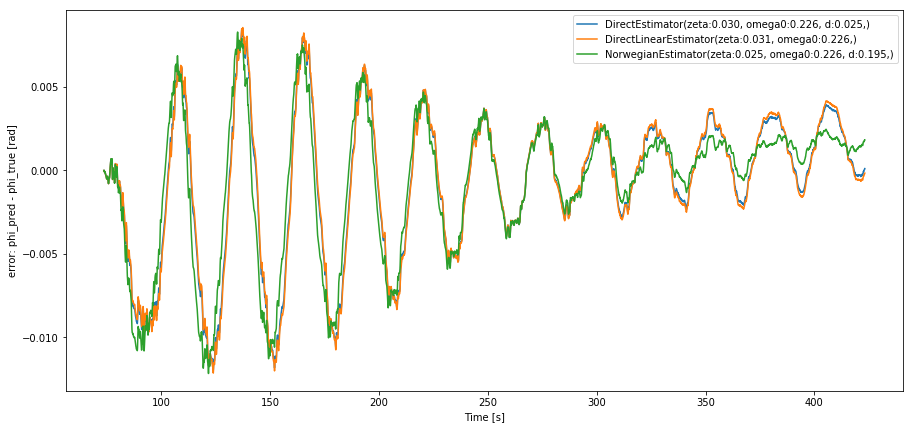

In [23]:
#file = df_direct_good.iloc[0].name
#file = '20084871056k.08.asc'


pipelines = [pipeline_directs, pipeline_direct_linears, pipeline_norwegians]

fig,ax = plt.subplots()
for p in pipelines:

    pipeline = p[file]
    estimator = pipeline[-1]
    estimator.plot_error(ax=ax)
    print('%s:%s' % (estimator.__class__.__name__,estimator.score(X=estimator.X)))


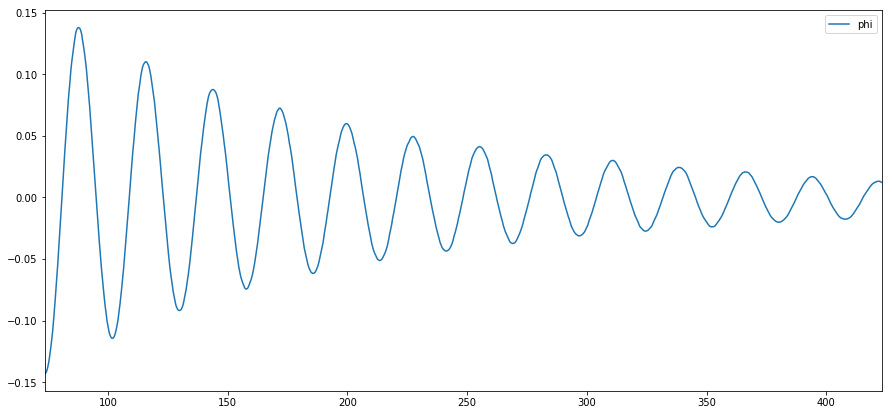

In [24]:
estimator.X.plot(y='phi')

In [25]:
df_direct_good.describe()

,d,mean_damping,omega0,score,zeta
count,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.106041,0.023065,0.220209,0.995218,0.021639
std,0.104749,0.010747,0.004022,0.004731,0.010942
min,0.000003,0.005635,0.214838,0.977519,0.005159
25%,0.008021,0.014288,0.218002,0.993962,0.012002
50%,0.063727,0.020955,0.219305,0.996465,0.019581
75%,0.213518,0.030540,0.220676,0.998518,0.029831
max,0.295409,0.049559,0.231413,0.999643,0.049555


In [26]:
df_norwegian_good.describe()

,d,mean_damping,omega0,score,zeta
count,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.127349,0.023191,0.220209,0.994915,0.021346
std,0.164754,0.011925,0.004022,0.005063,0.012957
min,-0.385117,0.004746,0.214838,0.977388,0.003057
25%,0.052436,0.013838,0.218002,0.993213,0.010305
50%,0.167447,0.020536,0.219305,0.996558,0.019894
75%,0.225282,0.031648,0.220676,0.998695,0.029650
max,0.650514,0.056879,0.231413,0.999617,0.060428


## The linear model is performing as good as the two quadratic for the present data
Need to investigate more ships to see if this changes...

In [27]:
df_direct_linear_good.describe()

,mean_damping,omega0,score,zeta,d
count,70.000000,70.000000,70.000000,70.000000,70.0
mean,0.024828,0.220209,0.994296,0.024828,0.0
std,0.010788,0.004022,0.005371,0.010788,0.0
min,0.005919,0.214838,0.972312,0.005919,0.0
25%,0.016321,0.218002,0.993081,0.016321,0.0
50%,0.022480,0.219305,0.995104,0.022480,0.0
75%,0.032300,0.220676,0.997985,0.032300,0.0
max,0.051067,0.231413,0.999369,0.051067,0.0


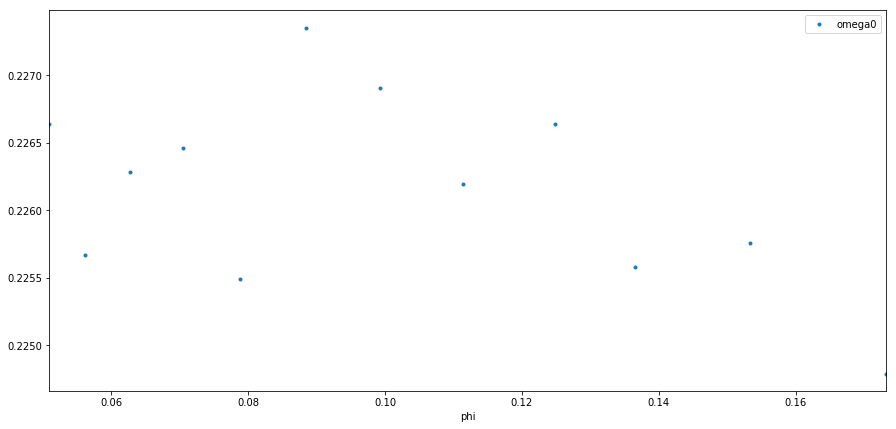

In [28]:
pipeline = pipeline_directs['20084871056k.14.asc']
estimator = pipeline[-1]
estimator.X_amplitudes.plot(x='phi',y='omega0',style='.')